In [189]:
# Load the data set

import pandas as pd
import numpy as np


train_data = pd.read_csv('./data/train.csv')
test_data= pd.read_csv('./data/test.csv')

train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [190]:
from collections import OrderedDict
import json
data_fields = OrderedDict()


def add_component(key):
    k,*v = key.split(': ')
    data_fields[k] = {
        'description': v[0],
        'components':{}
    }

    while '   ' in content[0]:
#         print(_)
        enrich_component(k, content.pop(0))
        if len(content)==0:
            break
    
    return k


def enrich_component(key, value:str):
    if value == "":
        return
    _ = value.strip().split(":")
    k,v = _[0],_[1]
    data_fields[key]['components'][k.upper()]=v.strip()

with open('./data/data_description.md', 'r') as f:
    content = list(f.readlines())
    _content = map(lambda i:i.replace('\n','').replace('\t\t','').replace('\t',': '),content)
    _content = filter(lambda j:j!=''and j!=': ', _content)
    content = list(_content)
#     pprint(content)
    while len(content)>0:
        current_k = add_component(content.pop(0))
#         print(current_k)
        
        if len(content)==0:
            break
            
def show_fields():
    for k in data_fields.keys():
        print(f'{k}\t–\tDescription: {data_fields[k]["description"]}')
        if len(data_fields[k]['components'])>0:
            print('Components\n', *list(f'\t- {i}: {j}\n' for i,j in data_fields[k]['components'].items()))
        print('============')


In [172]:
# show_fields()

# Shared Functions

In [191]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from pprint import pprint
import random


import seaborn as sns
import matplotlib.pyplot as plt


def plot_category(y_field, x_field:str="SalePrice"):
    sns.set(style="ticks", color_codes=True)
    g = sns.catplot(x=x_field, y=y_field, data=train_data);
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)


def get_color(existing_color=[])->str:
    r = lambda: random.randint(0,255)
    _color = '#%02X%02X%02X' % (r(),r(),r())
    _ = get_color(existing_color) if _color in existing_color else _color
    existing_color.append(_)
    return _

def plot_with_category(x_field:str, y_field:str='SalePrice'):
    y = train_data[y_field]
    x = pd.get_dummies(train_data[x_field])
    category = list(set(x.columns))
#     print(category, data_fields[x_field]["components"])
    chosen_color = []

    for c in category:
        # Plot outputs
        plt.scatter(x[c], y,  color=get_color(chosen_color))
        plt.title(label=f'{y_field} with respect to {data_fields[x_field]["components"][c.upper()]}')
#         plt.title(label=f'{y_field} with respect to {c}')
        # plt.plot(x, y, color='blue', linewidth=3)
        plt.show()

def pure_plot(x_field:str, y_field:str='SalePrice'):
    # Plot outputs
    plt.scatter(train_data[x_field], train_data[y_field],  color=get_color())
#     plt.plot(x, y, color='blue', linewidth=3)
    plt.show()
    
import time
def plot(x_field:str, y_field:str='SalePrice'):
    print(f'Field: {x_field}\nDescription: {data_fields[x_field]["description"]}')
    print('Components\n', *list(f'- {i}: {j}\n' for i,j in data_fields[x_field]['components'].items()))
    plot_category(x_field=y_field, y_field=x_field) if is_string_dtype(train_data[x_field]) else pure_plot(x_field, y_field)


In [193]:
# plot('Street')
# for f in data_fields.keys(): 
#     plot(f)


In [464]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html



def basic_data_set_info(train_data, test_data):
    num_train_data = train_data.shape[0]
    num_test_data = test_data.shape[0]
    print(f'Total record is {num_train_data+num_test_data}')
    print(f'Training set is {num_train_data}')
    print(f'Testing set is {num_test_data}')
    all_data = train_data.append(test_data,sort=False, ignore_index=True)
    print(f'Number of duplication (by id) is {all_data.shape[0] - len(set(all_data.Id))}')
    print(f'Number of features (except target prediction value): {all_data.shape[1]-1}')
    # 
    features = list(all_data.columns)
    features.remove('Id')
    features.remove('SalePrice')
    missing = (all_data[features].isnull().sum()/all_data[features].isnull().count()).sort_values(ascending=False)
    missing = pd.DataFrame({'Missing – NA(%)':round(missing[missing>0]*100,2)})
    print(missing.head(n=100))
    print(f'\n{missing.shape[0]} features have missing data')
#     missing_quant = (all_data[quantity].isnull().sum()/data_all[quantity].isnull().count()).sort_values(ascending=False)
#     missing_quant = missing_quant[missing_quant > 0] * 100
#     print("There are {} quantitative features with  missing values :".format(missing_quant.shape[0]))
#     missing_quant = pd.DataFrame({'Percent' :missing_quant})
#     missing_quant.head()
    return all_data



Total record is 2919
Training set is 1460
Testing set is 1459
Number of duplication (by id) is 0
Number of features (except target prediction value): 80
              Missing (%)
PoolQC              99.66
MiscFeature         96.40
Alley               93.22
Fence               80.44
FireplaceQu         48.65
LotFrontage         16.65
GarageCond           5.45
GarageQual           5.45
GarageYrBlt          5.45
GarageFinish         5.45
GarageType           5.38
BsmtCond             2.81
BsmtExposure         2.81
BsmtQual             2.77
BsmtFinType2         2.74
BsmtFinType1         2.71
MasVnrType           0.82
MasVnrArea           0.79
MSZoning             0.14
BsmtHalfBath         0.07
Utilities            0.07
Functional           0.07
BsmtFullBath         0.07
BsmtFinSF2           0.03
BsmtFinSF1           0.03
Exterior2nd          0.03
BsmtUnfSF            0.03
TotalBsmtSF          0.03
Exterior1st          0.03
SaleType             0.03
Electrical           0.03
KitchenQual    

Total record is 2919
Training set is 1460
Testing set is 1459
Number of duplication (by id) is 0
Number of features (except target prediction value): 80
              Missing (%)
PoolQC              99.66
MiscFeature         96.40
Alley               93.22
Fence               80.44
FireplaceQu         48.65
LotFrontage         16.65
GarageCond           5.45
GarageQual           5.45
GarageYrBlt          5.45
GarageFinish         5.45
GarageType           5.38
BsmtCond             2.81
BsmtExposure         2.81
BsmtQual             2.77
BsmtFinType2         2.74
BsmtFinType1         2.71
MasVnrType           0.82
MasVnrArea           0.79
MSZoning             0.14
BsmtHalfBath         0.07
Utilities            0.07
Functional           0.07
BsmtFullBath         0.07
BsmtFinSF2           0.03
BsmtFinSF1           0.03
Exterior2nd          0.03
BsmtUnfSF            0.03
TotalBsmtSF          0.03
Exterior1st          0.03
SaleType             0.03
Electrical           0.03
KitchenQual    

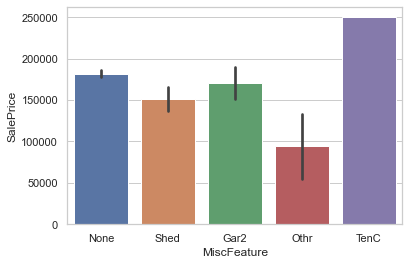

In [465]:
all_data = basic_data_set_info(train_data, test_data)
#
# from float type to int type
all_data.GarageYrBlt = all_data.GarageYrBlt.astype('Int64')
all_data[['GarageYrBlt','YearBuilt']]
_ = pd.DataFrame({'diff': all_data['GarageYrBlt']-all_data['YearBuilt']})

# print(f'Similarity GarageYrBlt and YearBuilt:{(_[ _["diff"]==0 ].count()/_.shape[0] *100)}%\n')

# Fillna by other field
all_data.GarageYrBlt = all_data.GarageYrBlt.fillna(all_data['YearBuilt'])
all_data[['GarageYrBlt','YearBuilt']]

# all_data[['GarageYrBlt','GarageType', 'GarageFinish', 'GarageCond', 'GarageQual']]

# Since the missing rate of Garage* features are very similar, we may check if they have the phenomon -> the garage may not really exist
# Filter out one of the null field
set_159 = all_data[
#     all_data['GarageType'].isnull()
    all_data['GarageFinish'].isnull()
#     all_data['GarageCond'].isnull()&
#     all_data['GarageQual'].isnull()
][['Id','GarageYrBlt','GarageType', 'GarageFinish', 'GarageCond', 'GarageQual', 'GarageArea', 'GarageCars']]


set_157 = all_data[
    all_data['GarageType'].isnull()&
    all_data['GarageFinish'].isnull()&
    all_data['GarageCond'].isnull()&
    all_data['GarageQual'].isnull()
][['Id','GarageYrBlt','GarageType', 'GarageFinish', 'GarageCond', 'GarageQual', 'GarageArea', 'GarageCars']]


print(f'Bias Id: {set(set_159.Id) - set(set_157.Id)}')

# Seems 2127 has carage while 2577 no
set_159[(set_159.Id == 2577) | (set_159.Id == 2127) ]

# TODO Clean 2577
# all_data[all_data.Id==2577].GarageType
# Clean 2127
# all_data[all_data.Id==2127] = all_data[all_data.Id==2127].fillna(all_data.mode().iloc[0])

# Fill na to be factor
all_data.GarageType = all_data.GarageType.fillna('NoGarage')

def convert_to_ordinary(all_data, order_val, field):
    print(f'{field} values: {set(all_data[field].values)}')
    valmap = {v:i for i,v in enumerate(order_val)}
    all_data[field] = all_data[field].replace(valmap)
    return all_data[field]

def fillna_by_mode(all_data, field:str):
    return all_data[field].fillna(all_data[field].mode().iloc[0])


# Convert the ordinal value
all_data.GarageFinish = convert_to_ordinary(all_data, [np.NaN, 'Unf', 'RFn', 'Fin'], 'GarageFinish')
all_data.GarageQual = convert_to_ordinary(all_data, [np.NaN, 'Po', 'Fa', 'TA','Gd','Ex'], 'GarageQual')
all_data.GarageCond = convert_to_ordinary(all_data, [np.NaN, 'Po', 'Fa', 'TA','Gd','Ex'], 'GarageCond')


# encode this variable as the values are ordinal

# Check the PoolArea
all_data.PoolQC = convert_to_ordinary(all_data, [np.NaN, 'Fa', 'TA','Gd','Ex'], 'PoolQC')

# There are 3 records that have PoolArea but do not have PoolQC -> consider to use the linear regression for OverallQual and PoolQC
all_data[(all_data.PoolQC==0)& (all_data.PoolArea>0)][['PoolQC', 'PoolArea', 'OverallQual']]
# By plotting the chat, we can see the trend PoolQC is matched with OverallQual
# plot(y_field='OverallQual', x_field='PoolQC')


# Handling MiscFeature, to eliminate the None value for future processing
all_data.MiscFeature = all_data.MiscFeature.fillna('None')
# x = sns.barplot(x="MiscFeature", y="SalePrice", data=all_data)

# Within Fireplace Quality, there are 1420 NAs. Number of fireplaces is complete.
print(f'Missing Fireplace is match: {all_data.Fireplaces[all_data.Fireplaces==0].count() == len(all_data.FireplaceQu[all_data.FireplaceQu.isnull()])}')
all_data.FireplaceQu = convert_to_ordinary(all_data, [np.NaN, 'Po', 'Fa', 'TA','Gd','Ex'], 'FireplaceQu')


all_data['Functional'] = fillna_by_mode(all_data, field='Functional')
# all_data.Functional[all_data.Functional.isnull()
all_data.Functional = convert_to_ordinary(all_data, ['Sal', 'Sev', 'Maj2','Maj1','Mod','Min2','Min1','Typ'], 'Functional')

all_data['SaleType'] = fillna_by_mode(all_data, field='SaleType')
all_data.SaleType[all_data.SaleType.isnull()]

all_data.FireplaceQu = convert_to_ordinary(all_data, [np.NaN, 'Po', 'Fa', 'TA','Gd','Ex'], 'FireplaceQu')

# 